# Clasificacion Basica: Predecir una imagen de moda

Esta Guia entrena un modelo de red neuronal para clasificar imagenes de ropa como, tennis y camisetas.

Esta Guia usa [tf.keras](https://www.tensorflow.org/guide/keras), un API de alto nivel para construir y entrenar modelos en Tensorflow.

In [1]:
# TensorFlow y tf.keras
import tensorflow as tf
from tensorflow import keras

# Librerias de ayuda
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2025-03-14 10:50:27.145411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.2


## Importar el set de datos de moda de MNIST

Esta guia usa el set de datos de [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)
que contiene mas de 70,000 imagenes en 10 categorias. Las imagenes muestran articulos individuales de ropa a una resolucion baja (28 por 28 pixeles) como se ve aca:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Para importar y cargar el set de datos de MNIST directamente de TensorFlow:

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

La *class* de ropa que la imagen representa.

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Cada imagen es mapeada a una unica etiqueta. Ya que los *Class names* no estan incluidos en el dataset. Los guardamos en la siguiente lista:

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore el set de datos

* ¿Cuántas imagenes hay en train?
* ¿Y en test?
* ¿De cuántos pixels se compone cada imagen?
* ¿Cuáles son los valores de los labels?

In [4]:
print(train_images.shape)

(60000, 28, 28)


In [5]:
print(test_images.shape)

(10000, 28, 28)


In [6]:
print(test_images.shape[1]*test_images.shape[2])

784


In [7]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

## Pre-procese el set de datos

Inspecciona y representa la primera imagen del dataset de train. Para ello, utiliza la función `imshow` de matplotlib.

In [8]:
train_labels[0]

9

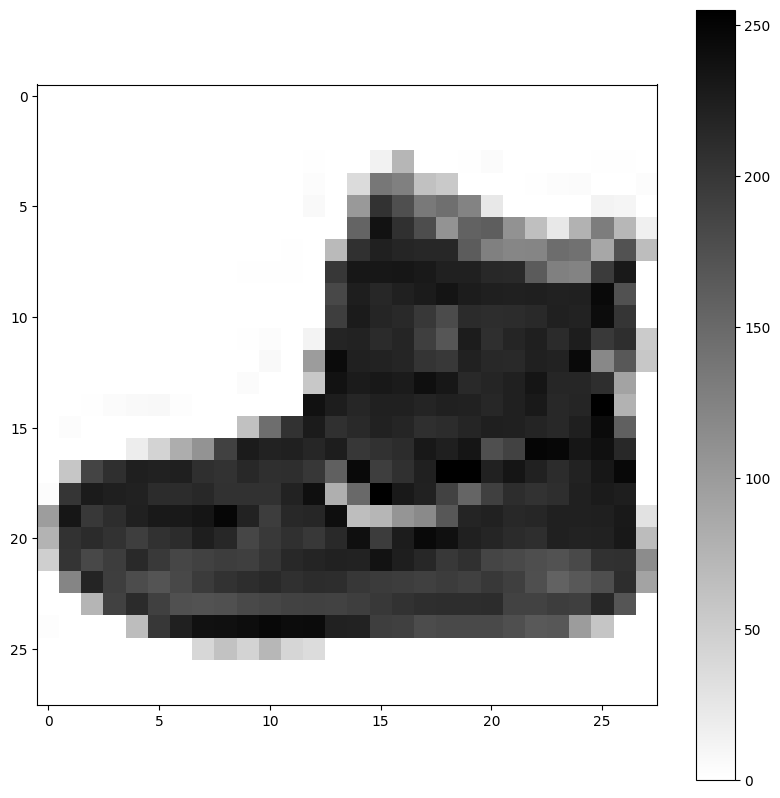

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()

Escala los conjuntos de train y test para que vayan del 0 al 1. No hace falta usar ninguna librería. Con realizar una división en cada conjunto será suficiente.

In [10]:
train_images = train_images/255
test_images = test_images/255

Para verificar que el set de datos esta en el formato adecuado y que estan listos para construir y entrenar la red, vamos a desplegar las primeras 25 imagenes de el *training set* y despleguemos el nombre de cada clase debajo de cada imagen.

In [11]:
for i in range(25):
    print(class_names[train_labels[i]])

Ankle boot
T-shirt/top
T-shirt/top
Dress
T-shirt/top
Pullover
Sneaker
Pullover
Sandal
Sandal
T-shirt/top
Ankle boot
Sandal
Sandal
Sneaker
Ankle boot
Trouser
T-shirt/top
Shirt
Coat
Dress
Trouser
Coat
Bag
Coat


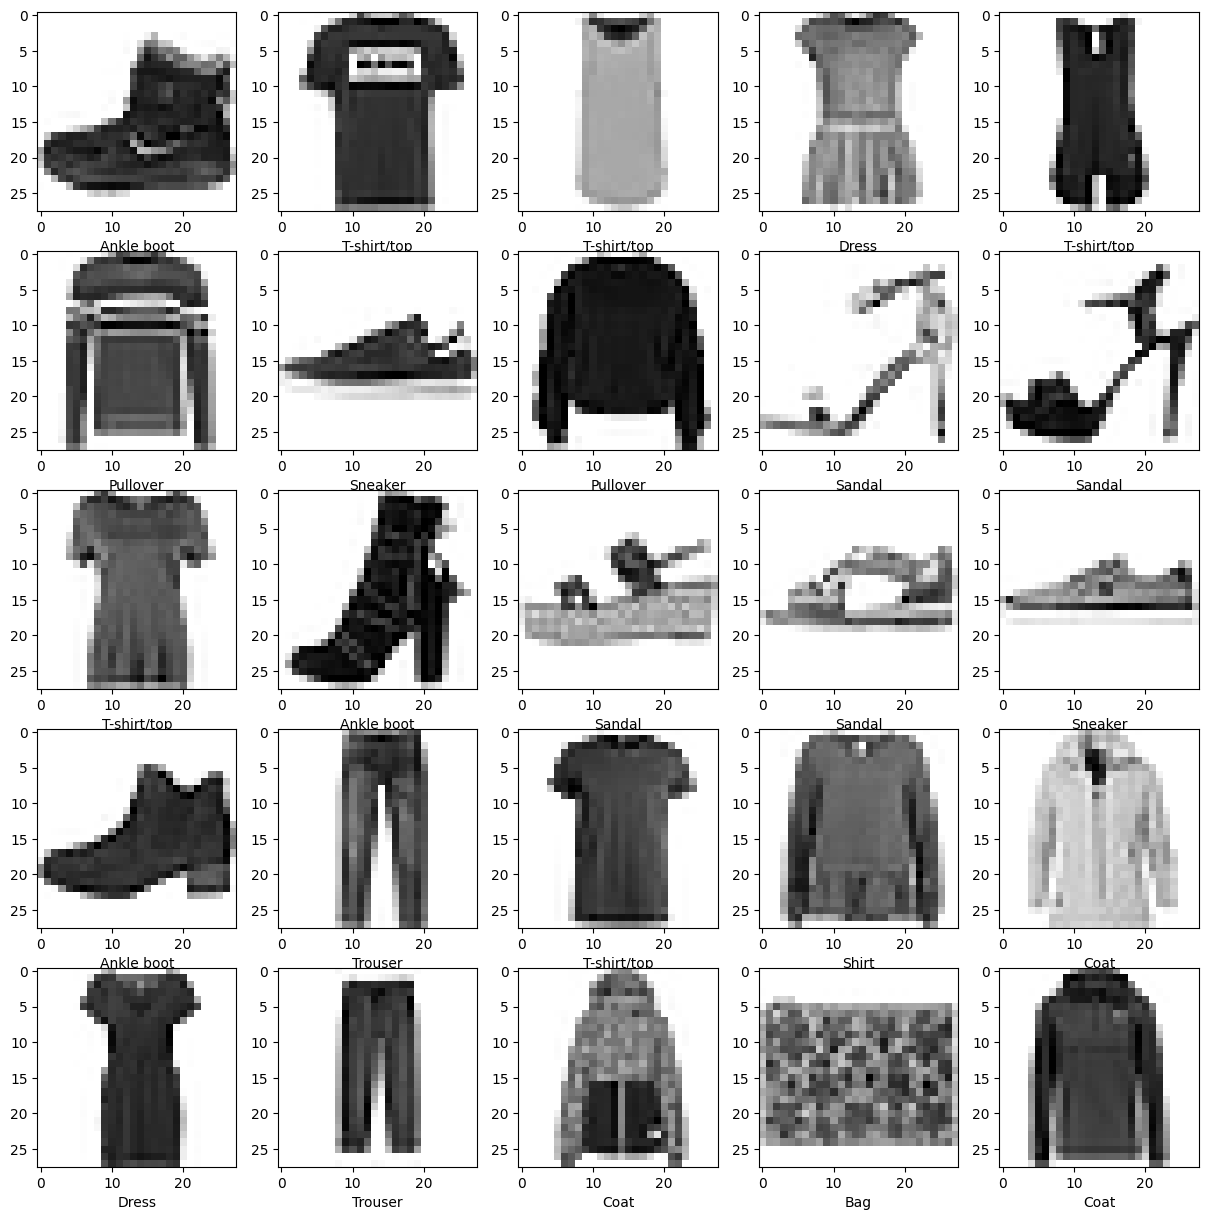

In [12]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5, i + 1)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

## Construir el Modelo

Construir la red neuronal requiere configurar las capas del modelo y luego compilar el modelo.

### Configurar las Capas
Construye todas las capas del modelo.

In [13]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compila el modelo

Antes de que el modelo este listo para entrenar , se necesitan algunas configuraciones mas. Estas son agregadas durante el paso de compilacion del modelo:

* *Loss function* —Esto mide que tan exacto es el modelo durante el entrenamiento. Quiere minimizar esta funcion para dirigir el modelo en la direccion adecuada.
* *Optimizer* — Esto es como el modelo se actualiza basado en el set de datos que ve y la funcion de perdida.
* *Metrics* — Se usan para monitorear los pasos de entrenamiento y de pruebas.

Prueba en el posterior entrenamiento varios optimizadores.

Como es un problema de clasificación multiclase, tendrás que usar `sparse_categorical_crossentropy` como función de coste. En cuanto a las métricas, usa simplemente `accuracy`.

In [14]:
model.compile(optimizer='adam',
              loss = "sparse_categorical_crossentropy",
              metrics = ['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,898 (491.79 KB)

 Trainable params: 125,898 (491.79 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenar el Modelo
Empieza entrenándolo con 10 epochs. Prueba con más

In [16]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7751 - loss: 0.6297
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8647 - loss: 0.3697
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8748 - loss: 0.3329
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8841 - loss: 0.3085
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8902 - loss: 0.2921
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8958 - loss: 0.2717
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9034 - loss: 0.2588
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9060 - loss: 0.2494
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9095 - loss: 0.2414
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9104 - loss: 0.2367


## Evaluar Accuracy
Prueba el rendimiento del modelo con los datos de test

In [17]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8825 - loss: 0.3400


In [18]:
test_acc

0.8845999836921692

## Hacer predicciones

Con el modelo entrenado puedes usarlo para hacer predicciones sobre imagenes.

In [19]:
predictions = model.predict(test_images)
print(predictions.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(10000, 10)


In [20]:
predictions[0]

array([7.7039140e-09, 1.5420720e-07, 3.2238539e-09, 1.9298277e-08,
       7.0148545e-09, 2.7266764e-03, 1.7504881e-08, 1.5590078e-03,
       3.4244709e-09, 9.9571413e-01], dtype=float32)

El modelo ha predecido la etiqueta para cada imagen en el set de datos de *test* (prueba). Miremos la primera prediccion:

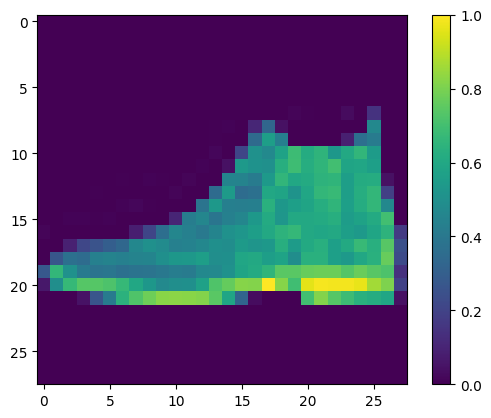

In [21]:
plt.figure()
plt.imshow(test_images[0])
plt.colorbar()

*una* prediccion es un array de 10 numeros. Estos representan el nivel de "confianza" del modelo sobre las imagenes de cada uno de los 10 articulos de moda/ropa. Puedes revisar cual tiene el nivel mas alto de confianza:

In [22]:
np.argmax(predictions[0])

9

Entonces, el modelo tiene mayor confianza que esta imagen es un bota de tobillo "ankle boot" o `class_names[9]`. Examinando las etiquetas de *test* o de pruebas muestra que esta clasificaion es correcta:

In [23]:
test_labels[0]

9

**Grafica** esto para poder ver todo el set de la prediccion de las 10 clases.

In [24]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Miremos la imagen [0], sus predicciones y el array de predicciones. Las etiquetas de prediccion correctas estan en azul y las incorrectas estan en rojo. El numero entrega el porcentaje (sobre 100) para la etiqueta predecida.

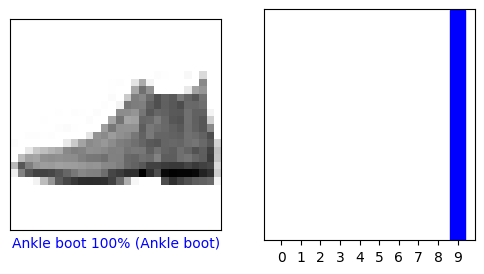

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

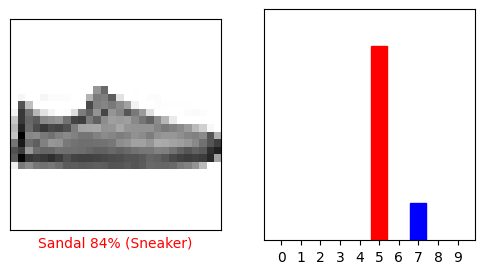

In [26]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Vamos a graficar multiples imagenes con sus predicciones. Notese que el modelo puede estar equivocado aun cuando tiene mucha confianza.

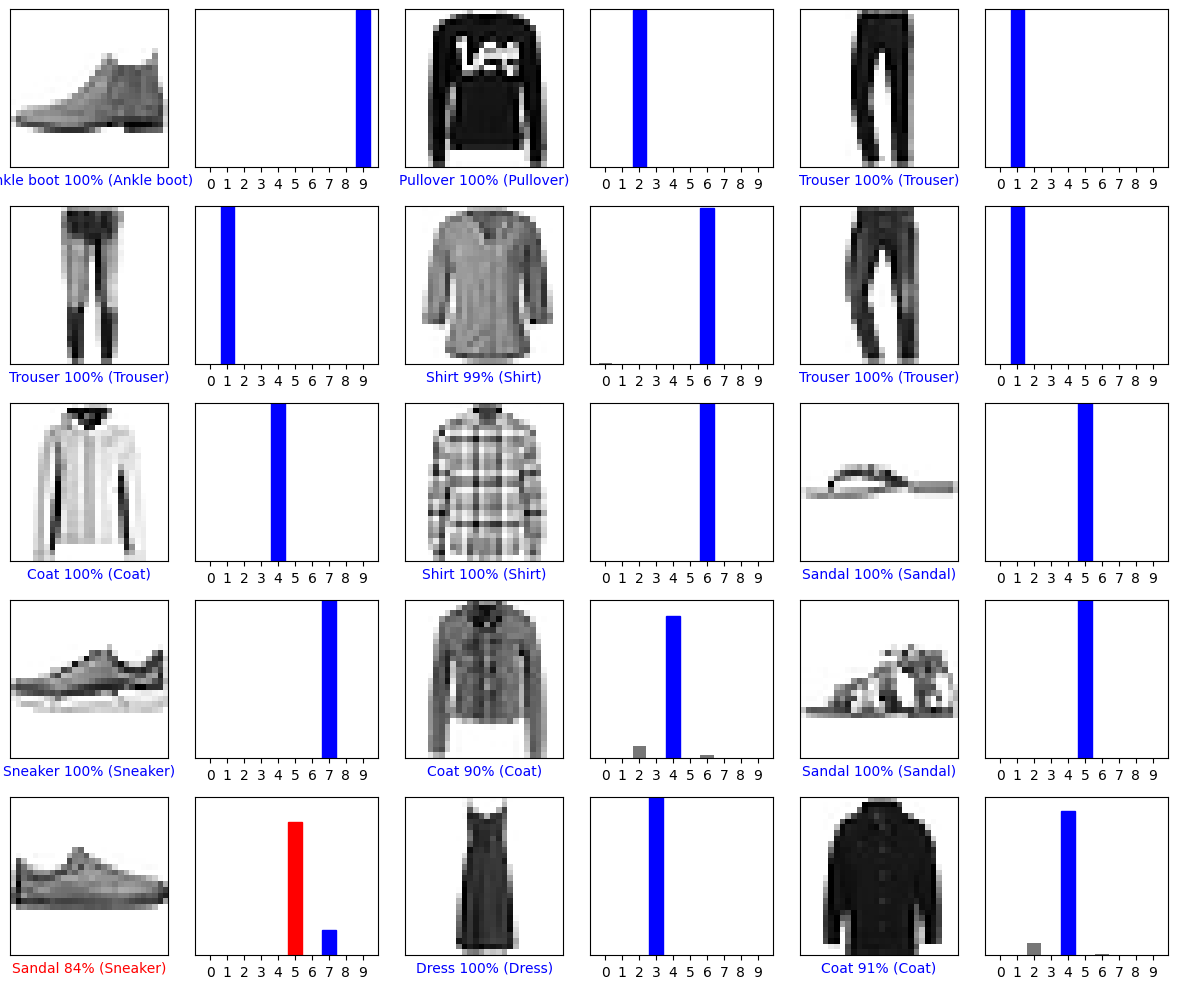

In [27]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Finalmente, usamos el modelo entrenado para hacer una prediccion sobre una unica imagen.

In [28]:
test_images.shape

(10000, 28, 28)

In [29]:
test_images[0:1].shape

(1, 28, 28)

In [30]:
model.predict(test_images[0:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


array([[7.7038846e-09, 1.5420690e-07, 3.2238476e-09, 1.9298277e-08,
        7.0148412e-09, 2.7266801e-03, 1.7504847e-08, 1.5590063e-03,
        3.4244645e-09, 9.9571413e-01]], dtype=float32)